In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(
            self, in_channels=3, num_classes=2, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.num_classes = num_classes

        # Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2, 
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], num_classes, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(2, size=skip_connections.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)
        
        return self.final_conv(x)

In [4]:
model = UNet(
    in_channels=3,   # RGB input
    num_classes=10,  # 10 output classes
    features=[64, 128, 256, 512]
)

x = torch.rand(2, 3, 256, 256)  # Batch of 2 RGB images
preds = model(x)  # Output shape: [2, 10, 256, 256]

print(x.shape)
print(preds.shape)

torch.Size([2, 3, 256, 256])
torch.Size([2, 10, 256, 256])


In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split


In [6]:
COLOUR_MAPPING = {
    (0, 255, 255): 0,    # Urban (Cyan)
    (255, 255, 0): 1,    # Agriculture (Yellow)
    (255, 0, 255): 2,    # Rangeland (Magenta)
    (0, 255, 0): 3,      # Forest (Green)
    (0, 0, 255): 4,      # Water (Blue)
    (255, 255, 255): 5,  # Barren (White)
    (0, 0, 0): 6         # Unknown (Black)
}

# Config
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
num_epochs = 5
num_workers = 0 #min(4, os.cpu_count())
height = 256 # 2448 originally
width = 256 # 2448 originally
pin_memory = True
load_model = False
# ImageNet mean/std for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [7]:
print(device)

cuda


In [8]:
class SatelliteDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.colour_mapping = COLOUR_MAPPING

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("_sat.jpg", "_mask.png"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask_rgb = np.array(Image.open(mask_path).convert("RGB"))

        mask = self.rgb_to_class(mask_rgb)
    
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask
    
    def get_path(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("_sat.jpg", "_mask.png"))
        return img_path, mask_path
    
    def rgb_to_class(self, mask_rgb):
        h, w = mask_rgb.shape[:2]
        mask_class = np.full((h, w), 6, dtype=np.int64)

        for rgb, class_idx in self.colour_mapping.items():
            # Find all pixels matching the current RGB value and assign the corresponding class index
            mask_class[(mask_rgb == rgb).all(axis=-1)] = class_idx

        return mask_class
    
    def display_sample(self, index, figsize=(15, 7)):
        """
        Display image and mask with titles showing:
        - Filename
        - Image dimensions
        - Unique classes present in mask
        """
        # Get the sample
        img_filename = self.images[index]
        image, mask = self[index]
        
        # Convert tensors to numpy if needed
        if torch.is_tensor(image):
            image = image.numpy().transpose(1, 2, 0)  # CHW to HWC
            image = (image * np.array(std) + np.array(mean)).clip(0, 1)  # Un-normalize
        
        if torch.is_tensor(mask):
            mask = mask.numpy()
        
        # Create colored mask
        colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
        for color, class_idx in self.colour_mapping.items():
            colored_mask[mask == class_idx] = color
        
        # Get unique classes in mask
        unique_classes = np.unique(mask)
        class_names = {
            0: 'Urban', 1: 'Agriculture', 2: 'Rangeland',
            3: 'Forest', 4: 'Water', 5: 'Barren', 6: 'Unknown'
        }
        present_classes = [class_names[c] for c in unique_classes]
        
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
        
        # Display image
        ax1.imshow(image)
        ax1.set_title(
            f"Image: {img_filename}\n"
            f"Shape: {image.shape}\n"
            f"Normalized: mean={mean}, std={std}",
            fontsize=10
        )
        ax1.axis('off')
        
        # Display mask
        ax2.imshow(colored_mask)
        ax2.set_title(
            f"Mask: {img_filename.replace('_sat.jpg', '_mask.png')}\n"
            f"Classes present: {', '.join(present_classes)}\n"
            f"Shape: {mask.shape}",
            fontsize=10
        )
        ax2.axis('off')
        
        # Add color legend
        legend_elements = [
            plt.Rectangle((0,0),1,1, color=np.array(color)/255, label=f'{class_idx}: {class_names[class_idx]}')
            for color, class_idx in self.colour_mapping.items()
        ]
        plt.legend(
            handles=legend_elements,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            title="Class Colors"
        )
        
        plt.tight_layout()
        plt.show()
    


In [9]:
train_transform = A.Compose([
    A.Resize(height, width),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(height, width),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

# train_dataset (object), train_dataset[idx] (img-mask pair), train_dataset[idx][idx] (corresponding img/mask matrix)
train_dataset = SatelliteDataset(
    image_dir="data/training_data/images",
    mask_dir="data/training_data/masks",
    transform=train_transform
)

test_dataset = SatelliteDataset(
    image_dir="data/test_data/images",
    mask_dir="data/test_data/masks",
    transform=test_transform
)

In [10]:
from torch.utils.data import DataLoader
import torch.optim as optim

In [11]:


print(type(train_dataset[0][0]))

<class 'torch.Tensor'>


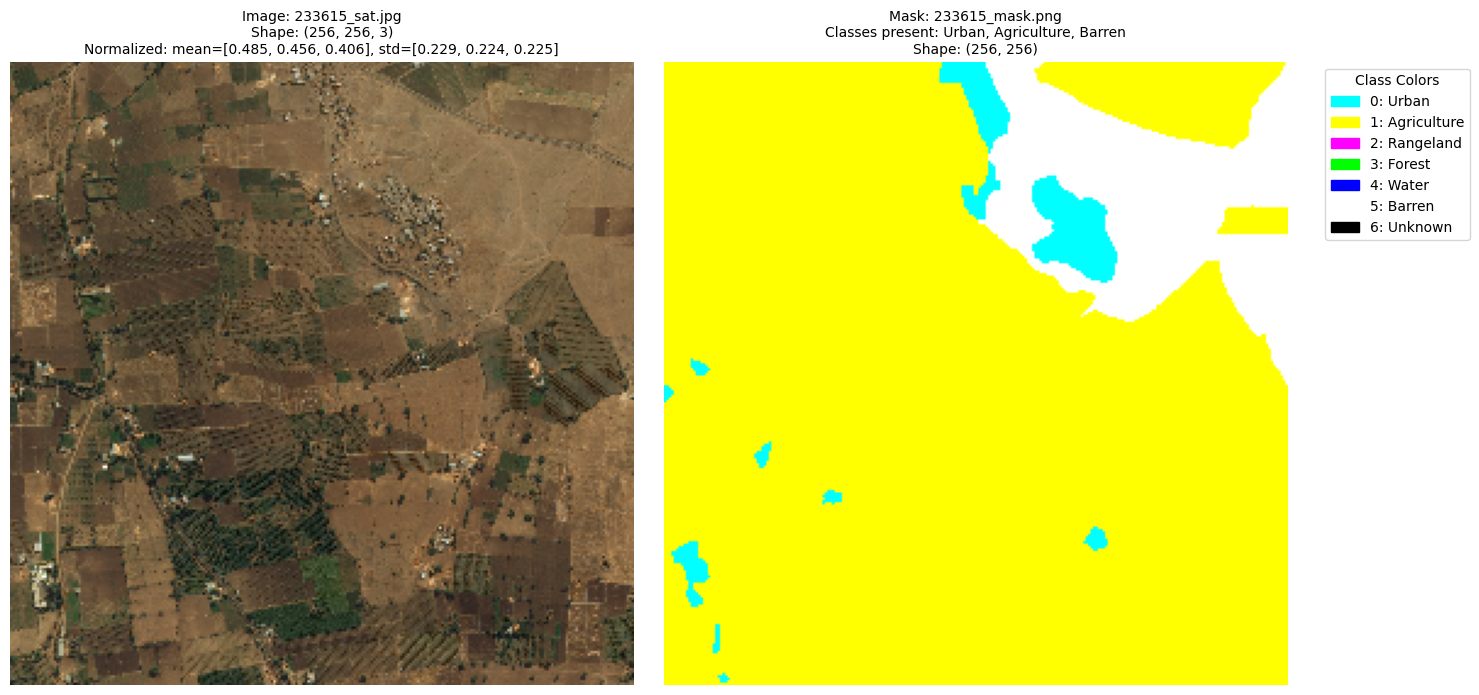

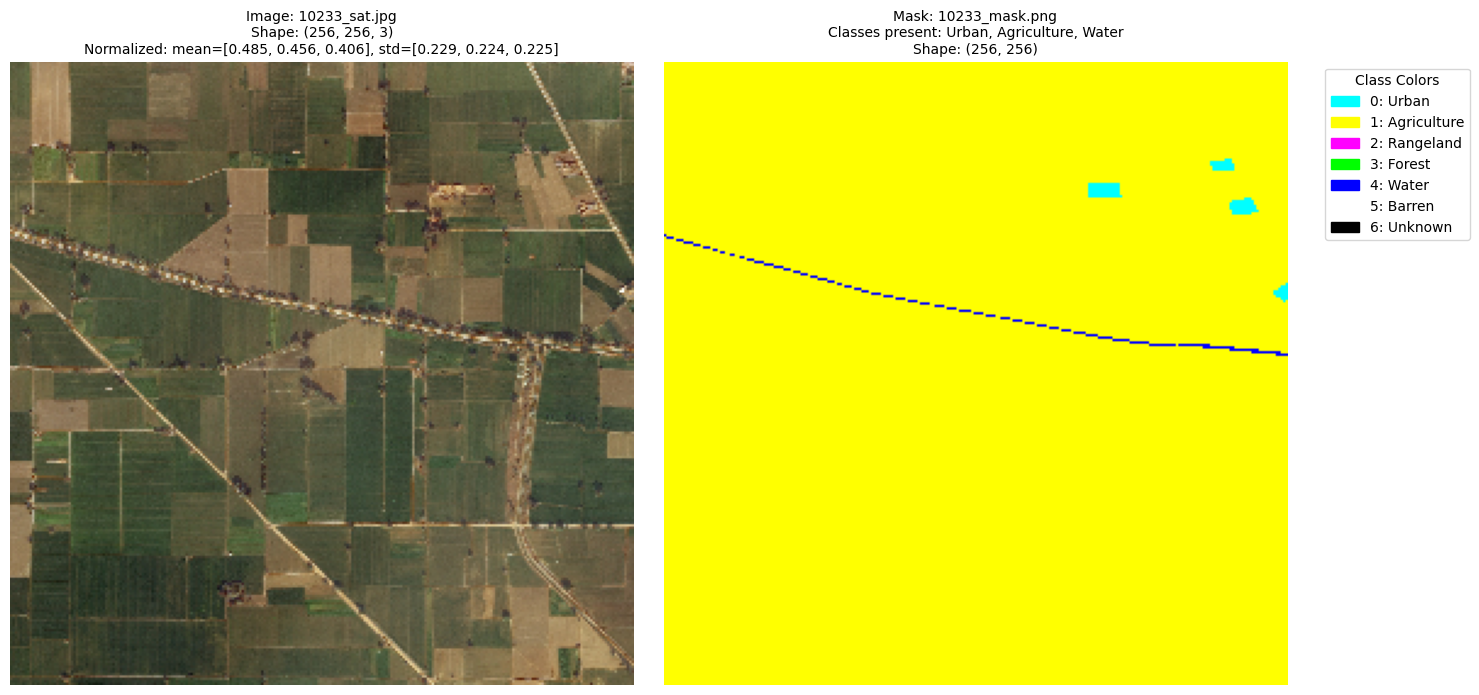

In [12]:
train_dataset.display_sample(1)
test_dataset.display_sample(2)

In [13]:
from tqdm import tqdm

In [14]:
def calculate_iou(preds, targets, num_classes=7):
    """
    Calculate Intersection over Union (IoU) for multi-class segmentation.
    """
    iou = 0
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)

        intersection = (pred_cls & target_cls).sum().item()
        union = (pred_cls | target_cls).sum().item()

        if union > 0:
            iou += intersection / union

    return iou / num_classes  # Average IoU across all classes

def train_epoch(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    for batch_idx, (data, target) in enumerate(loop):
        data = data.to(device=device)
        target = target.long().to(device=device)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, target)
    
        #backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss=loss.item())

def eval_model(loader, model, loss_fn, device):
    model.eval()  # Set the model to evaluation mode
    loop = tqdm(loader, desc="Evaluating")
    total_loss = 0
    num_batches = 0
    iou_score = 0  # Optional: IoU metric

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch_idx, (data, targets) in enumerate(loop):
            data = data.to(device=device)
            targets = targets.long().to(device=device)  # Ensure targets are in the correct format

            # Forward pass
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()
            num_batches += 1

            # Optional: Calculate IoU
            preds = torch.argmax(predictions, dim=1)  # Get predicted class indices
            iou_score += calculate_iou(preds, targets)  # Custom IoU function

            # Update progress bar
            loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches
    avg_iou = iou_score / num_batches  # Average IoU across batches (if IoU is calculated)

    print(f"Validation Loss: {avg_loss:.4f}, Average IoU: {avg_iou:.4f}")
    return avg_loss, avg_iou
        
    

In [15]:
def main():
    torch.cuda.empty_cache()
    
    # Initialize best_iou at the start
    best_iou = 0.0
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    
    # Create model with correct number of classes (7)
    model = UNet(
        in_channels=3,
        num_classes=7,  # Changed from 10 to match your 7 classes
        features=[64, 128, 256, 512]
    ).to(device=device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(num_epochs):
        model.train()
        train_epoch(train_loader, model, optimizer, loss_fn, scaler)
        
        val_loss, val_iou = eval_model(test_loader, model, loss_fn, device)
        
        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
                'iou': val_iou,
            }, "best_unet.pth")
            print(f"Saved new best model with IoU: {val_iou:.4f}")
        
        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Best IoU: {best_iou:.4f}")
    
    print(f"Training complete. Best IoU: {best_iou:.4f}")

In [ ]:
if __name__ == '__main__':
    main()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_23664\759815236.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
  0%|          | 0/43 [00:00<?, ?it/s]C:\Users\Administrator\AppData\Local\Temp\ipykernel_23664\1931815134.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
 49%|████▉     | 21/43 [03:40<03:50, 10.49s/it, loss=1.55]